C:\Users\Shakshi Singh\Documents\anaconda\envs\shakshi\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.6419 - val_loss: 0.6389
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4510 - val_loss: 0.5098
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4512 - val_loss: 0.4762
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4515 - val_loss: 0.4687
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4515 - val_loss: 0.4665
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4527 - val_loss: 0.4657
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4498 - val_loss: 0.4653
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4496 - val_loss: 0.4650
Epoch 9/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4511 - val_loss: 0.4647
Epoch 10/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4496 - val_loss: 0.4646
Epoch 11/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4512 - val_loss: 0.4644
Epoch 12/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

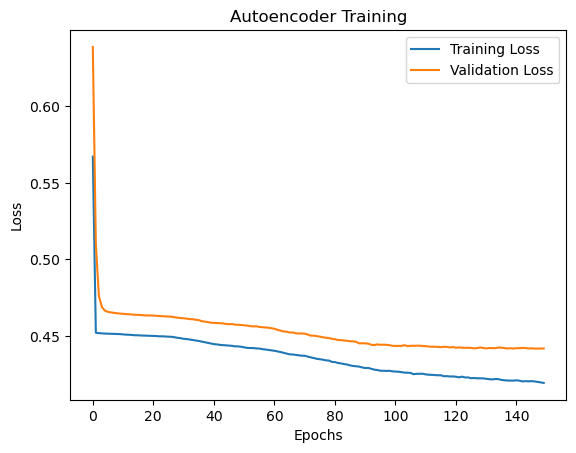

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Threshold for fault detection: 0.5387

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       293
           1       0.25      0.19      0.22        21

    accuracy                           0.91       314
   macro avg       0.60      0.57      0.58       314
weighted avg       0.90      0.91      0.90       314

ROC-AUC Score: 0.55
Confusion Matrix:
 [[281  12]
 [ 17   4]]


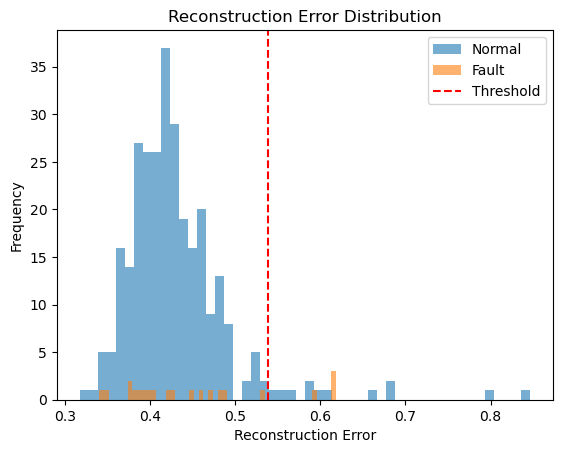

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

# Load the data
# Replace the file paths with the actual paths if running locally
secom_data = pd.read_csv(r'C:\Users\Shakshi Singh\Documents\ml project\secom.data', sep=' ', header=None)
secom_labels = pd.read_csv(r'C:\Users\Shakshi Singh\Documents\ml project\secom_labels.data', sep=' ', header=None)

# Preprocessing
## 1. Extract features and labels
features = secom_data.copy()
labels = secom_labels[0]

## 2. Encode labels (1: fault, 0: normal)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

## 3. Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

## 4. Scale features for standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

## 5. Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels)


# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Autoencoder with BatchNormalization and more layers
autoencoder = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Bottleneck layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(X_train_scaled.shape[1], activation='sigmoid')  # Reconstruct the input
])

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mae')

# Filter Normal Data (Assuming Label '0' is Normal)
X_train_normal = X_train_scaled[y_train == 0]

# Train Autoencoder on Normal Data
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=150,  # Increased epochs
    batch_size=64,  # Adjusted batch size
    validation_split=0.2,
    verbose=1
)

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Compute Reconstruction Errors on Test Data
reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.abs(X_test_scaled - reconstructed), axis=1)

# Set Threshold for Fault Detection (based on validation set)
threshold = np.percentile(reconstruction_error, 95)
print(f"Threshold for fault detection: {threshold:.4f}")

# Classify as Faulty (1) or Normal (0)
y_pred_autoencoder = (reconstruction_error > threshold).astype(int)

# Evaluate Model Performance
print("\nClassification Report:\n", classification_report(y_test, y_pred_autoencoder))
roc_score = roc_auc_score(y_test, reconstruction_error)
print(f"ROC-AUC Score: {roc_score:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_autoencoder)
print("Confusion Matrix:\n", cm)

# Visualize Reconstruction Errors
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Fault')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()